In [401]:
from ThesisPackage.Environments.collectors.collectors_env_discrete_onehot import Collectors
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [402]:
def make_env(sequence_length=0, max_timesteps=128):
    vocab_size = 4
    env = Collectors(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_timesteps=max_timesteps, timestep_countdown=15)
    # env = ParallelFrameStack(env, 4)
    return env

In [403]:
def load(path="models/checkpoints", sequence_length=2):
    env = make_env(sequence_length)

    state_dict = torch.load(path)
    agent = PPO_Multi_Agent_Centralized(env, device="cpu")
    agent.agent.load_state_dict(state_dict)
    return agent

In [404]:
def plot_language_saliencies(full_saliences, path=None):
    plt.figure(figsize=(20, 5))  # Adjust figure size to make it more readable

    plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

    plt.plot(plot_saliences[:, -1], label='Channel 2')
    plt.plot(plot_saliences[:, -2], label="Channel 1")
    # plt.plot(saliencies)
    plt.title('Saliency of language channel')
    plt.xlabel('Timestep')
    plt.ylabel('Saliency Sum')
    plt.legend()
    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [405]:
import copy

def record_data(env, data):
    data["ball_1"].append(copy.deepcopy(env.balls["ball_1"]["position"]))
    data["ball_2"].append(copy.deepcopy(env.balls["ball_2"]["position"]))
    data["direction_1"].append(copy.deepcopy(env.balls["ball_1"]["direction"]))
    data["direction_2"].append(copy.deepcopy(env.balls["ball_2"]["direction"]))
    data["player_1"].append(copy.deepcopy(env.paddles["player_1"]))
    data["player_2"].append(copy.deepcopy(env.paddles["player_2"]))
    data["distances"].append(copy.deepcopy(abs(env.paddles["paddle_1"] - env.paddles["paddle_2"])))
    try:
        data["utterance player_1"].append(copy.deepcopy(env.utterances["player_1"].tolist()))
        data["utterance player_2"].append(copy.deepcopy(env.utterances["player_2"].tolist()))
    except:
        data["utterance player_1"].append(copy.deepcopy(env.utterances["player_1"]))
        data["utterance player_2"].append(copy.deepcopy(env.utterances["player_2"]))
    return data

In [406]:
def perturbation(inputs, model, vocab_size, sequence_length):
    
    # Extract environment inputs
    environment_inputs = inputs[:, :-1 * vocab_size * sequence_length]

    # Extract original logits
    inputs = torch.tensor(inputs, dtype=torch.float32)
    original_logits = model(inputs)
    original_logits = F.softmax(original_logits, dim=1).detach().numpy()
    original_logits = F.log_softmax(torch.tensor(original_logits), dim=1).detach()

    perturbation_logits = []
    for token in range(vocab_size):
        # One-hot encoded sequence of tokens
        utterances = np.array([token for _ in range(sequence_length)])
        utterances = np.eye(vocab_size)[utterances].flatten()
        utterances = np.expand_dims(utterances, axis=0)
        utterances = np.repeat(utterances, inputs.shape[0], axis=0)

        # Concatenate environment inputs with utterances
        perturbation_inputs = np.concatenate((environment_inputs, utterances), axis=1)
        perturbation_inputs = torch.tensor(perturbation_inputs, dtype=torch.float32)

        # Get logits for perturbed inputs
        current_logits = model(perturbation_inputs).detach().numpy()
        current_logits = F.softmax(torch.tensor(current_logits), dim=1).detach().numpy()

        perturbation_logits.append(current_logits)

    divergences = []
    for input_array in perturbation_logits:
        kl_divergences = []
        for i in range(len(input_array)):
            q = F.softmax(torch.tensor(input_array[i]), dim=0)
            kl_div = F.kl_div(original_logits, q, reduction='batchmean').item()
            kl_divergences.append(kl_div)

        divergences.append(kl_divergences)
    max_divergences = np.max(divergences, axis=0)
    return max_divergences

In [407]:
def test_perturbation_saliency(env, agent, epochs=1, tracking_agent="player_1"):
    language_importances = []
    saliencies = []

    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    data = {"ball_1": [], "ball_2": [], "direction_1":[], "direction_2":[], "paddle_1": [], "paddle_2": [], "distances":[], "utterance paddle_1":[], "utterance paddle_2":[]}

    for i in range(epochs):
        timestep = 0
        while True:
            timestep += 1
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            # data = record_data(env, data)
            
            # integrated_grads = smoothgrad(obs_track, agent.agent.actor, 0, sigma=1.0, steps=30)
            language_perturbation = perturbation(obs, agent.agent.actor, env.vocab_size, env.sequence_length)
            language_importances.append(language_perturbation)

            # If any of language_importances is higher thnan 0.002
            obs_track = torch.tensor(obs, dtype=torch.float32, requires_grad=True)

            logits = agent.agent.actor(obs_track)
            grad_tensor = torch.zeros_like(logits)
            grad_tensor[:, :-1 * env.sequence_length * env.vocab_size] = 1

            logits.backward(grad_tensor)

            saliency = obs_track.grad.data.abs()

            saliency = saliency.numpy()
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

            average_language = np.sum(saliency[:, -1 * env.sequence_length * env.vocab_size:], axis=1)
            saliencies.append(average_language)

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
    return np.array(language_importances), np.array(saliencies)

In [408]:
num_steps = 10000
agent = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/checkpoints_collectors_2/models/collectors_seq_2.pt", sequence_length=2)
env = make_env(sequence_length=2, max_timesteps=512)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [409]:
length = 0
while length < 500:
    importances, saliencies = test_perturbation_saliency(env, agent, epochs=1)
    length = len(saliencies)

In [410]:
import matplotlib.pyplot as plt

def plot_importances(data, title):
    # Plot the two lines
    plt.figure(figsize=(14, 4))
    plt.plot(data[:, 0], label='Agent 1')
    plt.plot(data[:, 1], label='Agent 2')
    plt.title(title)
    ax = plt.gca()
    ax.set_xlim([0, len(data)])
    ax.set_ylabel('KL Divergence')
    ax.set_xlabel('Timestep')
    plt.legend()
    plt.grid(True)
    plt.savefig("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Perturbation/collectors_long.pdf")

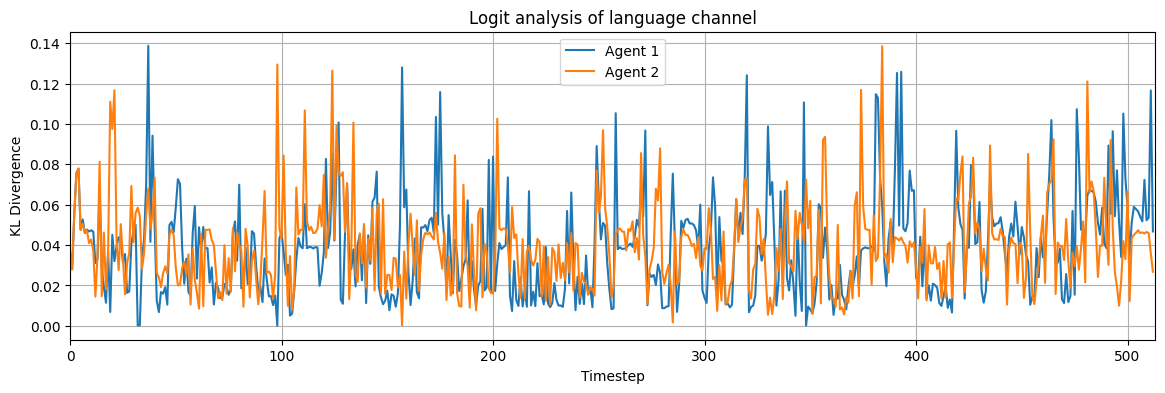

In [411]:
plot_importances(importances, "Logit analysis of language channel")

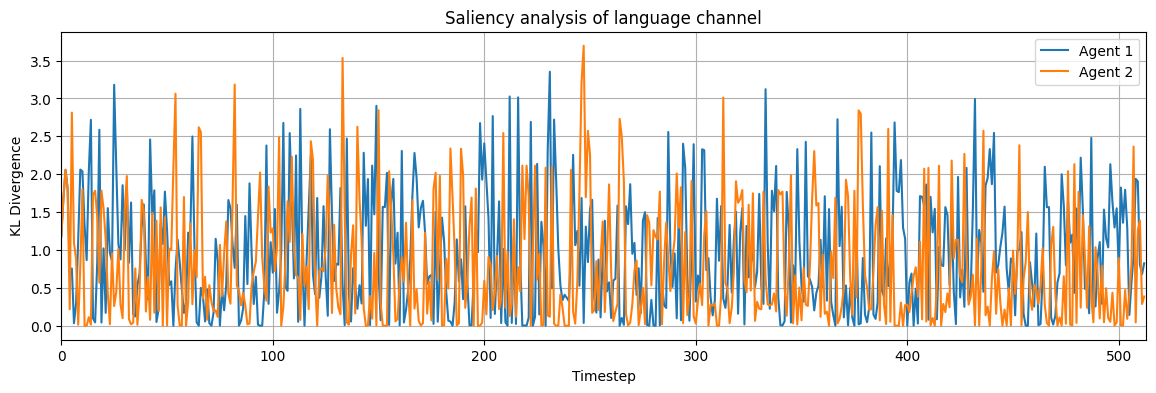

In [412]:
plot_importances(saliencies, "Saliency analysis of language channel")